## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [2]:
df=pd.read_csv("../input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [3]:
features=df["img"]
labels=df["classname"]

In [4]:
df["classname"].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

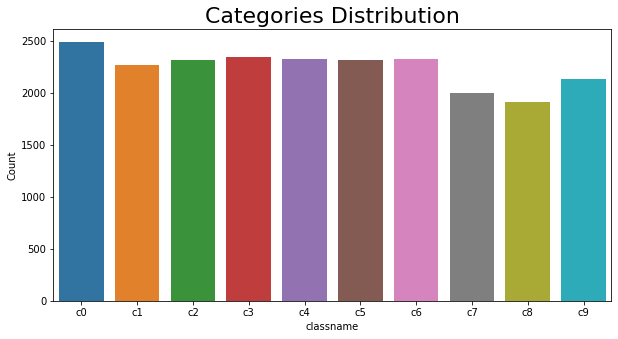

In [5]:
plt.figure(figsize = (10,5))
# Count the number of images per category
sns.countplot(x = 'classname',data = df)

plt.title('Categories Distribution'.title(),size=22 )
plt.xlabel('classname')
plt.ylabel('Count')

plt.show()

In [6]:
path="../input/state-farm-distracted-driver-detection/imgs/train"
folder_names=os.listdir(path)
folder_names

['c5', 'c7', 'c8', 'c2', 'c6', 'c4', 'c3', 'c1', 'c9', 'c0']

In [7]:
for i,folder in enumerate( folder_names):
    print(folder,"contains",len(os.listdir(path+"/"+folder)))

c5 contains 2312
c7 contains 2002
c8 contains 1911
c2 contains 2317
c6 contains 2325
c4 contains 2326
c3 contains 2346
c1 contains 2267
c9 contains 2129
c0 contains 2489


### Reading Images GrayScale

In [8]:
def read_gray():
    base="../input/state-farm-distracted-driver-detection/imgs/train"
    image_data=[]
    label_data=[]
    for i in range(len (features)):
        img = cv2.resize(cv2.imread(base+"/"+labels[i]+"/"+ features[i], cv2.IMREAD_GRAYSCALE),(64,64))
        image_data.append(img)
        label_data.append(labels[i])
    return image_data, label_data

### Reading Images RGB

In [9]:
def read_color():    
    path="../input/state-farm-distracted-driver-detection/imgs/train"
    image_data=[]
    label_data=[]
    for i in range(len (features)):
        img=cv2.imread(path+"/"+labels[i]+"/"+ features[i],cv2.IMREAD_COLOR)
        img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ,(64,64))
        image_data.append(img)
        label_data.append(labels[i])
    return image_data,label_data

### Splitting Dataset

In [10]:
def split(image_data,label_data):
    train_images, images_validation_test, train_labels, labels_validation_test = train_test_split(
        image_data, label_data, test_size=0.2, random_state=42, stratify=labels)
    validation_images, test_images, validation_labels, test_labels = train_test_split(
        images_validation_test, labels_validation_test, test_size=0.5,random_state=42,stratify=labels_validation_test)
    train_images=np.asarray(train_images)
    validation_images=np.asarray(validation_images)
    test_images=np.asarray(test_images)
    
    train_labels=np.asarray(train_labels)
    validation_labels=np.asarray(validation_labels)
    test_labels=np.asarray(test_labels)
    return train_images,train_labels,validation_images,validation_labels,test_images,test_labels

### Data Preprocessing

In [11]:
def feature_preprocessing(train_images,validation_images,test_images):
    train_images = train_images.reshape((train_images.shape[0], -1))
    train_images = train_images.astype('float32') / 255

    validation_images = validation_images.reshape((validation_images.shape[0], -1))
    validation_images = validation_images.astype('float32') / 255

    test_images = test_images.reshape((test_images.shape[0],-1))
    test_images = test_images.astype('float32') / 255
    return train_images,validation_images,test_images

In [12]:
def label_preprocessing(train_labels,validation_labels,test_labels):   
    label_encoder = LabelEncoder()
    vec = label_encoder.fit_transform(train_labels)
    train_labels = to_categorical(vec)
    vec = label_encoder.fit_transform(validation_labels)
    validation_labels = to_categorical(vec)
    vec = label_encoder.fit_transform(test_labels)
    test_labels = to_categorical(vec)
    return train_labels,validation_labels,test_labels

### Baseline Dense layers model

In [13]:
image_data, label_data=read_gray()
train_images,train_labels,validation_images,validation_labels,test_images,test_labels=split(image_data,label_data)
train_images,validation_images,test_images=feature_preprocessing(train_images,validation_images,test_images)
train_labels,validation_labels,test_labels=label_preprocessing(train_labels,validation_labels,test_labels)

In [14]:
dense_model = models.Sequential()
dense_model.add(layers.Dense(256, activation='relu', name='Layer_1', input_shape=(64*64*1,)))
dense_model.add(layers.Dense(256, activation='relu', name='Layer_2'))
dense_model.add(layers.Dense(128, activation='relu', name='Layer_3'))
dense_model.add(layers.Dense(128, activation='relu', name='Layer_4'))
dense_model.add(layers.Dense(10, activation='softmax'))

In [15]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
Layer_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
Layer_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
Layer_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 1,165,322
Trainable params: 1,165,322
Non-trainable params: 0
_________________________________________________________________


In [16]:
dense_model.compile(optimizer=optimizers.Adam(learning_rate=10e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
history = dense_model.fit(train_images, train_labels,
            validation_data=(validation_images,validation_labels),
            epochs=20, batch_size=128)

Epoch 1/20
141/141 [==============================] - 2s 5ms/step - loss: 2.4380 - accuracy: 0.2799 - val_loss: 1.3880 - val_accuracy: 0.4554
Epoch 2/20
141/141 [==============================] - 0s 3ms/step - loss: 1.1722 - accuracy: 0.5387 - val_loss: 1.0774 - val_accuracy: 0.5910
Epoch 3/20
141/141 [==============================] - 0s 3ms/step - loss: 0.9282 - accuracy: 0.6510 - val_loss: 1.1214 - val_accuracy: 0.5803
Epoch 4/20
141/141 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.7671 - val_loss: 0.5272 - val_accuracy: 0.8087
Epoch 5/20
141/141 [==============================] - 0s 3ms/step - loss: 0.5940 - accuracy: 0.7948 - val_loss: 0.7571 - val_accuracy: 0.7199
Epoch 6/20
141/141 [==============================] - 0s 3ms/step - loss: 0.4260 - accuracy: 0.8548 - val_loss: 0.4454 - val_accuracy: 0.8515
Epoch 7/20
141/141 [==============================] - 0s 4ms/step - loss: 0.4397 - accuracy: 0.8480 - val_loss: 0.5395 - val_accuracy: 0.8109
Epoch 

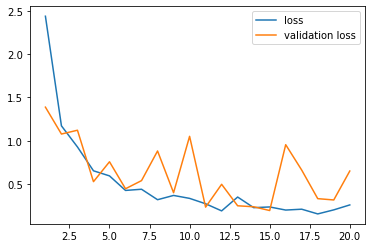

In [18]:
plt.plot(range(1, 21), history.history['loss'], label='loss')
plt.plot(range(1, 21), history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

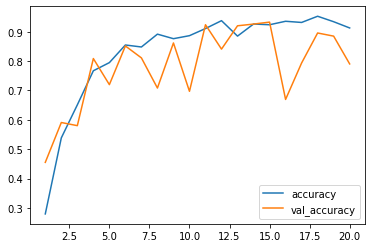

In [19]:
plt.plot(range(1, 21), history.history['accuracy'], label='accuracy')
plt.plot(range(1, 21), history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [22]:
test_loss, test_acc = dense_model.evaluate(test_images, test_labels)

71/71 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.7833


### Baseline CNN model

In [24]:
image_data, label_data=read_color()
train_images,train_labels,validation_images,validation_labels,test_images,test_labels=split(image_data,label_data)
train_labels,validation_labels,test_labels=label_preprocessing(train_labels,validation_labels,test_labels)
train_images = train_images.astype('float32') / 255
validation_images = validation_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [34]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64,64,3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

In [35]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [36]:
model_cnn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
history_cnn=model_cnn.fit(train_images, train_labels, 
                          validation_data=(validation_images,validation_labels),
                          epochs=20,
                          batch_size=128)

Epoch 1/20
141/141 [==============================] - 3s 14ms/step - loss: 1.1383 - accuracy: 0.6229 - val_loss: 0.2892 - val_accuracy: 0.9237
Epoch 2/20
141/141 [==============================] - 2s 11ms/step - loss: 0.2066 - accuracy: 0.9406 - val_loss: 0.2400 - val_accuracy: 0.9273
Epoch 3/20
141/141 [==============================] - 2s 12ms/step - loss: 0.0789 - accuracy: 0.9778 - val_loss: 0.0854 - val_accuracy: 0.9768
Epoch 4/20
141/141 [==============================] - 2s 11ms/step - loss: 0.0403 - accuracy: 0.9881 - val_loss: 0.0400 - val_accuracy: 0.9897
Epoch 5/20
141/141 [==============================] - 2s 11ms/step - loss: 0.0216 - accuracy: 0.9935 - val_loss: 0.0701 - val_accuracy: 0.9871
Epoch 6/20
141/141 [==============================] - 2s 11ms/step - loss: 0.0161 - accuracy: 0.9954 - val_loss: 0.2244 - val_accuracy: 0.9389
Epoch 7/20
141/141 [==============================] - 2s 11ms/step - loss: 0.0092 - accuracy: 0.9977 - val_loss: 0.0336 - val_accuracy: 0.9938

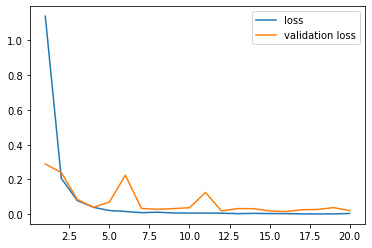

In [38]:
plt.plot(range(1, 21), history_cnn.history['loss'], label='loss')
plt.plot(range(1, 21), history_cnn.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

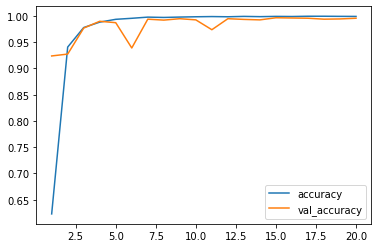

In [39]:
plt.plot(range(1, 21), history_cnn.history['accuracy'], label='accuracy')
plt.plot(range(1, 21), history_cnn.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [40]:
test_loss, test_acc = model_cnn.evaluate(test_images, test_labels)

71/71 [==============================] - 0s 3ms/step - loss: 0.0372 - accuracy: 0.9929


## Data augmentation

In [42]:
train_datagen = ImageDataGenerator(rotation_range=40)
dev_datagen = ImageDataGenerator(rotation_range=40)
train_datagen.fit(train_images)
dev_datagen.fit(validation_images)

In [43]:
model_aug = models.Sequential()
model_aug.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64,64,3)))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_aug.add(layers.MaxPooling2D((2, 2)))
model_aug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_aug.add(layers.Flatten())
model_aug.add(layers.Dense(256, activation='relu', name='Layer_1'))
model_aug.add(layers.Dense(128, activation='relu', name='Layer_2'))
model_aug.add(layers.Dense(10, activation='softmax'))

In [46]:
model_aug.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 256)               1

In [44]:
model_aug.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

In [48]:
history_aug = model_aug.fit(
    train_datagen.flow(train_images, train_labels, batch_size=256,),
         validation_data=dev_datagen.flow(validation_images, validation_labels,
         batch_size=256),
          epochs=20)

Epoch 1/20
71/71 [==============================] - 19s 263ms/step - loss: 1.3263 - acc: 0.5363 - val_loss: 0.8743 - val_acc: 0.7079
Epoch 2/20
71/71 [==============================] - 19s 262ms/step - loss: 0.8161 - acc: 0.7261 - val_loss: 0.4938 - val_acc: 0.8519
Epoch 3/20
71/71 [==============================] - 19s 262ms/step - loss: 0.5233 - acc: 0.8318 - val_loss: 0.3538 - val_acc: 0.8894
Epoch 4/20
71/71 [==============================] - 19s 265ms/step - loss: 0.3506 - acc: 0.8915 - val_loss: 0.2293 - val_acc: 0.9393
Epoch 5/20
71/71 [==============================] - 19s 265ms/step - loss: 0.2561 - acc: 0.9222 - val_loss: 0.3131 - val_acc: 0.8818
Epoch 6/20
71/71 [==============================] - 19s 262ms/step - loss: 0.2007 - acc: 0.9397 - val_loss: 0.1483 - val_acc: 0.9523
Epoch 7/20
71/71 [==============================] - 18s 258ms/step - loss: 0.1560 - acc: 0.9519 - val_loss: 0.1294 - val_acc: 0.9590
Epoch 8/20
71/71 [==============================] - 18s 260ms/step - 

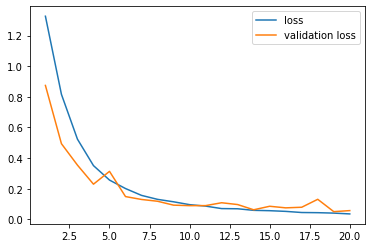

In [49]:
plt.plot(range(1, 21), history_aug.history['loss'], label='loss')
plt.plot(range(1, 21), history_aug.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

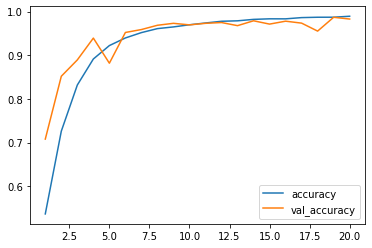

In [52]:
plt.plot(range(1, 21), history_aug.history['acc'], label='accuracy')
plt.plot(range(1, 21), history_aug.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()

In [53]:
test_loss, test_acc = model_aug.evaluate(test_images, test_labels)

71/71 [==============================] - 0s 3ms/step - loss: 0.0554 - acc: 0.9840


## **Transfer Learning**

In [70]:
train_datagen = ImageDataGenerator(rotation_range=40)
dev_datagen = ImageDataGenerator(rotation_range=40)
train_datagen.fit(train_images)
dev_datagen.fit(validation_images)

In [71]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))
model_tl = models.Sequential()
model_tl.add(conv_base)
model_tl.add(layers.Flatten())
model_tl.add(layers.Dense(256, activation='relu', name='Layer_1'))
model_tl.add(layers.Dense(128, activation='relu', name='Layer_2'))
model_tl.add(layers.Dense(10, activation='softmax'))
model_tl.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

In [72]:
model_tl.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
Layer_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 15,273,418
Trainable params: 15,273,418
Non-trainable params: 0
_________________________________________________________________


In [73]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [74]:
tl_history = model_tl.fit(
    train_datagen.flow(train_images, train_labels, batch_size=256,),
         validation_data=dev_datagen.flow(validation_images, validation_labels,
         batch_size=256),
          epochs=25)

Epoch 1/25
71/71 [==============================] - 21s 281ms/step - loss: 107.1339 - acc: 0.1090 - val_loss: 2.3343 - val_acc: 0.1035
Epoch 2/25
71/71 [==============================] - 20s 276ms/step - loss: 2.3363 - acc: 0.1141 - val_loss: 2.3638 - val_acc: 0.1035
Epoch 3/25
71/71 [==============================] - 20s 282ms/step - loss: 2.3723 - acc: 0.1109 - val_loss: 2.3005 - val_acc: 0.1111
Epoch 4/25
71/71 [==============================] - 20s 276ms/step - loss: 2.4211 - acc: 0.1060 - val_loss: 2.3037 - val_acc: 0.1012
Epoch 5/25
71/71 [==============================] - 19s 271ms/step - loss: 2.3224 - acc: 0.1068 - val_loss: 2.0693 - val_acc: 0.1922
Epoch 6/25
71/71 [==============================] - 20s 274ms/step - loss: 2.2511 - acc: 0.1425 - val_loss: 2.0396 - val_acc: 0.1757
Epoch 7/25
71/71 [==============================] - 20s 282ms/step - loss: 1.6716 - acc: 0.3485 - val_loss: 1.4696 - val_acc: 0.4103
Epoch 8/25
71/71 [==============================] - 20s 278ms/step 

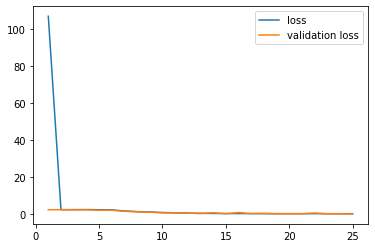

In [75]:
plt.plot(range(1, 26), tl_history.history['loss'], label='loss')
plt.plot(range(1, 26), tl_history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

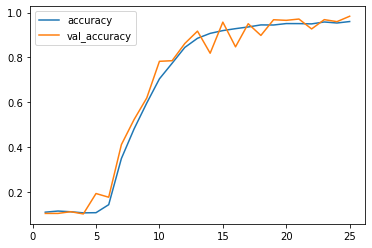

In [76]:
plt.plot(range(1, 26), tl_history.history['acc'], label='accuracy')
plt.plot(range(1, 26), tl_history.history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()

In [77]:
test_loss, test_acc = model_tl.evaluate(test_images, test_labels)

71/71 [==============================] - 1s 10ms/step - loss: 0.0974 - acc: 0.9835
